Stajesz przed nowym zadaniem, nowy product manager poprosił Cię o pomoc w obliczeniu i wizualizacji nowego KPI, który ma
pomóc ulepszyć proces dostarczania rezultatów do klienta. Jego definicja to: Ilość zaakceptowanych błędów na godzinę w 
pierwszych 6-ciu godzinach od rozpoczęcia cyklu testowego. PM przekazał Ci, że dla uproszczenia jako początek cyklu testowego możesz uznać czas pierwszego zgłoszonego błędu. 

Jeżeli uda Ci się pokazać tą metrykę, PM napewno doceni analizę na tych danych - ponieważ on nie ma na to czasu.

Stwórz widok pokazujący powyższą metryke i zaproponuj dodatkowe wykresy z które mogą być przydatne dla Product Manager'a.

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
data = pd.read_csv('cycle_data.csv')

In [3]:
data.sample(10)

,issue_code_,created_at,severity,resolution,affected_components,creator_id
67,CYCLE-10-68,13/04/2021 17:03:58,Medium,Duplicate,{Workouts},6435.0
61,CYCLE-10-62,13/04/2021 16:45:50,Medium,Confirmed (S),{Workouts},6435.0
14,CYCLE-10-15,13/04/2021 15:51:34,High,Confirmed (S),{Content},8049.0
77,CYCLE-10-78,13/04/2021 17:43:56,Medium,Confirmed (S),{Settings},8124.0
3,CYCLE-10-4,13/04/2021 15:41:38,High,Confirmed (S),{Signup},4075.0
71,CYCLE-10-72,13/04/2021 17:09:32,Medium,Confirmed (S),{Workouts},5589.0
85,CYCLE-10-86,13/04/2021 19:14:45,Low,Confirmed (S),{Workouts},7594.0
11,CYCLE-10-12,13/04/2021 15:49:31,High,Confirmed (S),{Signup},1066.0
83,CYCLE-10-84,13/04/2021 19:01:57,High,Duplicate,{Login},6435.0
53,CYCLE-10-54,13/04/2021 16:35:00,Medium,Confirmed (S),{Signup},6380.0


In [4]:
data.severity.unique()

array(['Low', 'High', 'Medium', 'Critical'], dtype=object)

In [5]:
data.resolution.unique()

array(['Confirmed (S)', 'Duplicate', 'Expected Behaviour',
       'Confirmed (!)', 'Invalid - not tester error', 'Not in Scope',
       'No tester response', 'Confirm (S)'], dtype=object)

In [6]:
data.affected_components.unique()

array(['{Signup}', '{Profile}', 'Profile', '{Sign-up}', '{Content}',
       '{Challenge}', '{Workouts}', '{Settings}', '{Kit}', '{Guides}',
       '{Meals}', '{Login}'], dtype=object)

In [7]:
# First step will be to clear the data.
# I replace rows where resolution status is 'Confirmed (!)' and 'Confirm (S)' with status 'Confirmed (S)', because it's 
# the same category 

data["resolution"].replace({"Confirmed (!)": "Confirmed (S)", "Confirm (S)": "Confirmed (S)"}, inplace=True)
data.resolution.unique()

array(['Confirmed (S)', 'Duplicate', 'Expected Behaviour',
       'Invalid - not tester error', 'Not in Scope', 'No tester response'],
      dtype=object)

In [8]:
data.isnull().sum()

issue_code_            0
created_at             1
severity               0
resolution             0
affected_components    0
creator_id             1
dtype: int64

In [9]:
# Drop rows where NaN is in 'created_at' column, because we need this data to check if error was created within first 
# 6 hours of testing cycle.

data.dropna(subset=['created_at'], inplace=True)
data['created_at'].isnull().sum()

0

In [10]:
type(data['created_at'][0])

str

In [11]:
# I want to change data type in column "created_at" to datetime 
# There is an error appearing because of wrong format in one row, so I'm going to change this

data[data['created_at'] == '04/13/2021 16:25:40']

,issue_code_,created_at,severity,resolution,affected_components,creator_id
44,CYCLE-10-45,04/13/2021 16:25:40,High,Confirmed (S),{Workouts},4693.0


In [12]:
data.at[44, 'created_at'] = '13/04/2021 16:25:40'
data.loc[44, 'created_at']

'13/04/2021 16:25:40'

In [13]:
# Change format 
data['created_at'] = pd.to_datetime(data['created_at'], format='%d/%m/%Y %H:%M:%S')

In [14]:
type(data['created_at'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [15]:
# Now I'm going to create a new column 'cycle_hour' with information about hour of testing cycle (from 1 to 6) in which error appeared
start_date = data.loc[0, 'created_at']
end_date = start_date + pd.DateOffset(hours=1)
start_date, end_date

(Timestamp('2021-04-13 15:35:36'), Timestamp('2021-04-13 16:35:36'))

In [16]:
for i in range(6):
    data.loc[(data['created_at'] >= start_date + pd.DateOffset(hours=i)) & (data['created_at'] < end_date + pd.DateOffset(hours=i)), 'cycle_hour'] = i+1

In [17]:
# Drop rows if issue appeared after 6 hours.
data.dropna(subset=['cycle_hour'], inplace=True)
data['cycle_hour'].isnull().sum()

0

In [18]:
data.sample(5)

,issue_code_,created_at,severity,resolution,affected_components,creator_id,cycle_hour
13,CYCLE-10-14,2021-04-13 15:51:06,Low,Confirmed (S),{Profile},3230.0,1.0
87,10-88,2021-04-13 19:42:28,Medium,Confirmed (S),{Workouts},6435.0,5.0
19,CYCLE-10-20,2021-04-13 15:58:32,Medium,Confirmed (S),{Profile},3230.0,1.0
88,CYCLE-10-89,2021-04-13 20:08:18,Medium,Confirmed (S),{Profile},7594.0,5.0
90,CYCLE-10-91,2021-04-13 20:44:48,Medium,Confirmed (S),{Profile},7594.0,6.0


In [19]:
confirmed_data = data[data['resolution'] == 'Confirmed (S)']

In [20]:
confirmed_data['cycle_hour'].unique()

array([1., 2., 3., 4., 5., 6.])

In [21]:
confirmed_by_hours = (
    confirmed_data
    .groupby(['cycle_hour'])
    ['issue_code_'].count()
    .reset_index()
    .rename(columns={'issue_code_': 'number_of_issues'})
    
)

confirmed_by_hours

,cycle_hour,number_of_issues
0,1.0,47
1,2.0,16
2,3.0,4
3,4.0,5
4,5.0,2
5,6.0,5


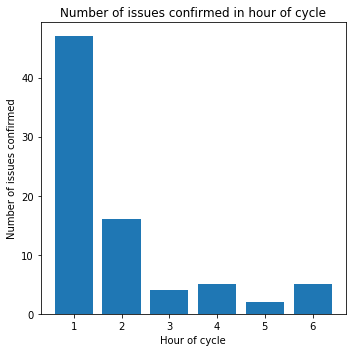

In [22]:
# Plot1: number of issues in 6 hours after starting the testing cycle 

plt.figure(figsize=(5,5))
plt.bar(confirmed_by_hours.cycle_hour, confirmed_by_hours.number_of_issues, width=0.8, align='center')
plt.xlabel('Hour of cycle')
plt.ylabel('Number of issues confirmed')
plt.title('Number of issues confirmed in hour of cycle')
plt.savefig('Issues per hour.pdf')
plt.tight_layout()
plt.show()

In [46]:
severity_data = confirmed_data
severity_data = severity_data.reset_index().groupby(['cycle_hour', 'severity'])['issue_code_'].aggregate('count').unstack()
severity_data.fillna(0.0, inplace=True)
severity_data

severity,Critical,High,Low,Medium
cycle_hour,,,,
1.0,3.0,12.0,17.0,15.0
2.0,1.0,5.0,3.0,7.0
3.0,0.0,2.0,1.0,1.0
4.0,0.0,2.0,1.0,2.0
5.0,0.0,0.0,0.0,2.0
6.0,0.0,1.0,1.0,3.0


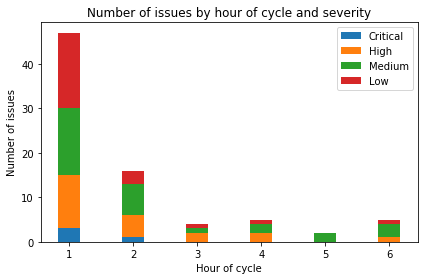

In [77]:
# Plot2: number of issues in 6 hours after starting the testing cycle by severities

critical = np.array(severity_data['Critical'])
high = np.array(severity_data['High'])
medium = np.array(severity_data['Medium'])
low = np.array(severity_data['Low'])

x = np.arange(6)    
width = 0.35       

fig, ax = plt.subplots()

p1 = ax.bar(x, critical, width, label='Critical')
p2 = ax.bar(x, high, width,bottom= critical, label='High')
p3 = ax.bar(x, medium, width,bottom= critical + high, label='Medium')
p4 = ax.bar(x, low, width, bottom= critical+ high + medium,
             label='Low')


ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Number of issues')
ax.set_xlabel('Hour of cycle')
ax.set_title('Number of issues by hour of cycle and severity')
ax.set_xticks(x)
ax.set_xticklabels(['1', '2', '3', '4', '5', '6'])
ax.legend()

plt.tight_layout()
plt.savefig('Issues by hour and severity.pdf')
plt.show()

In [57]:
# Plot 3: number of issues by affected components
# Preparing data

confirmed_data['affected_components'].unique()

array(['{Signup}', '{Profile}', 'Profile', '{Content}', '{Challenge}',
       '{Workouts}', '{Kit}', '{Guides}', '{Meals}', '{Settings}',
       '{Login}'], dtype=object)

In [60]:
confirmed_data['affected_components'].replace({'Profile': '{Profile}'}, inplace=True)
confirmed_data['affected_components'].unique()

array(['{Signup}', '{Profile}', '{Content}', '{Challenge}', '{Workouts}',
       '{Kit}', '{Guides}', '{Meals}', '{Settings}', '{Login}'],
      dtype=object)

In [69]:
affected_components = (
    confirmed_data
    .groupby(['affected_components'])
    ['issue_code_'].count()
    .reset_index()
    .rename(columns={'issue_code_': 'number_of_issues', 'affected_components': 'components'})
    .sort_values(by='number_of_issues', ascending=False)
)
affected_components

,components,number_of_issues
6,{Profile},22
9,{Workouts},19
8,{Signup},14
1,{Content},7
3,{Kit},5
0,{Challenge},4
2,{Guides},3
5,{Meals},3
4,{Login},1
7,{Settings},1


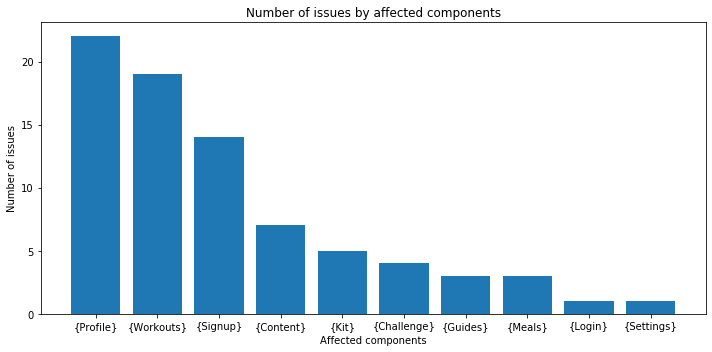

In [71]:
plt.figure(figsize=(10,5))
plt.bar(affected_components.components, affected_components.number_of_issues, width=0.8, align='center')
plt.xlabel('Affected components')
plt.ylabel('Number of issues')
plt.title('Number of issues by affected components')
plt.savefig('Number of issues by affected components.pdf')
plt.tight_layout()
plt.show()